---
jupyter: python3
cache: True

---

<a href="https://colab.research.google.com/github/Fonzzy1/LLM-Workshop/blob/main/workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LLMs for Communications Methods**
##### Presented at the ADM+S 2026 Summer School as the interactive component of
# **Integrating LLMs into communication research methods: Possibilities, assumptions and risks**


This session will provide users with a hands-on opportunity to see how language models can be integrated into communications research, and what possibilities and risks this presents.

<br>

*Authors: Alfie Chadwick and Laura Vodden*

<br>

# **Part 1. Setting up**

### **1.1 Housekeeping**

**Before you proceed**

The default runtime type of Colab instances is CPU based. We will need to change our runtime type to **T4 GPU** or better.
Change this by either going to **Runtime > Change runtime type**

*or*

by going to the tiny arrow in the top right corner of your browser and selecting ***Change runtime type**.

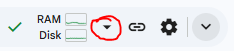

While running your script be mindful of the resources you're using. This can be tracked in the same menu at **View resources**.

Source [here](https://colab.research.google.com/github/5aharsh/collama/blob/main/Ollama_Setup.ipynb#scrollTo=o2ghppmRDFny).

### **1.2 Set up ollama environment, and install and import libraries**
This should only take a minute or two.

In [ ]:
#!sudo apt update
#!sudo apt install -y pciutils zstd
#!curl -fsSL https://ollama.com/install.sh | sh
!pip install ollama kagglehub kagglehub[pandas-datasets]

# Fancy little subprocess trick to get ollama working in Colab workbooks
import subprocess
proccess = subprocess.Popen(['ollama', 'serve'], stdout=subprocess.DEVNULL,
stderr=subprocess.DEVNULL, stdin=subprocess.DEVNULL, close_fds=True)

### **1.3 Model selection**

We are going to be using **four** Large Language Models today:
* Llama
* Qwen
* Gemma
* Deepseek



All of these models are **open source**, and all but Gemma are the same size.  
However, they will exhibit slight differences when we ask them the same
question.

For other models check https://ollama.com/library

<br>


> 🏃 **Run the cell below** to 'pull' our models from the ollama library. This could take up to 3 minutes.

In [ ]:
!ollama pull llama3.1:8b
!ollama pull qwen3:8b
!ollama pull gemma3:4b
!ollama pull deepseek-r1:8b

print('Done!')

<br>

# **Part 2. Interacting with LLMs in Python**

Unlike interacting with a chat client online, using LLMs in Python is much more
flexible but takes a little time to set up.

In Python we can create **functions** - repeatable pieces of code using the `def`
syntax. We can pass **arguments** to these functions, which change how the function behaves.

Below is a function that takes two arguments:
    1.a **prompt**; and
    2.the name of the **model** we want to use

<br>

> 🏃 **Run the cell below** to **define** the **function**. We will **call** this function later.

In [ ]:
import ollama

def query_llm(prompt, model):
    """
    Given a 'prompt' and the name of a model,
    return the LLM's text response (uses ollama SDK).
    Because the model has a default, we don't need to be explicit in which model
    to use if you don't want to.
    """
    # Send the request to Ollama and get the response
    response = ollama.chat(
        model=model, messages=[{"role": "user", "content": prompt}]
    )
    # Return ONLY the LLM's textual answer from the response
    return response.message.content

Now that we have **defined** a working **function**, we can look at some responses from the different
models.

<br>

> ✍ Change the **prompt** in the cell below to something that is within your field of expertise - but try to ask for a brief response.

In [ ]:
# Examples (ctrl+/ to use):
# prompt = 'What is the role of performance in australian parliamentary debates'
# prompt = 'Briefly tell me: What does a cat say?'
prompt = 'What is the definition of framing in communication science?'

We can now go and ask what each model says in response using the function that
was defined above.

<br>


> 🏃 **Run the cell below** to **call** the function. The function **returns** a **response**, based on these arguments.

In [ ]:
for model in ['llama3.1:8b', 'qwen3:8b', 'gemma3:4b', 'deepseek-r1:8b']:
    print(f'{model} is analysing your question...\n')
    print("-" * 10)
    answer = query_llm(prompt, model)
    print(f'{model} says:\n{answer}\n')
    print("-" * 100)

### **🧐 Questions**


> *  What did the models get **right**, and what did they get **wrong**?
> *  How did the response **differ** between the different models?
> *  Which model gave the 'best' response, and **why** do you think that?
> *  Is this kind of output **useful**?


Try playing with a couple of
different questions or different ways of wording the questions to see if you get
different results.

<br>

# **Part 3. Using LLMs for communication research**

While we can use LLMs for question-answering tasks, as we did before, they are particularly for the **'busy work'** of research.


Tasks such as data **cleaning**, **labelling**, **classification** and **extraction** are relatively straightforward to automate and **validate**. By automating such processes, we can work with much larger datasets and address research questions at a different scale than would typically be feasible using manual methods.


While these approaches enable new analytical **possibilities**, they also introduce **risks** that warrant careful consideration. We will keep this in mind as we work through the following examples.






### **☝ Example: Narrative framing: Hero/villain extraction**

In this demo, we're going to expand on the work done by [Frermann et al.
(2023)](https://doi.org/10.18653/v1/2023.acl-long.486), which looks at how
**narrative actors** - in this case, heroes, victims and villains - are allocated within climate
discourse.

### **3.1 Dataset selection**

Dataset selection is one of the most important parts of computational
communications tasks as it defines the scope of questions that can be answered
by your later analysis.

Today, we are using pre-built **Twitter Climate Change Sentiment** dataset  from
[Kaggle](https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset), for ease of access.

This dataset contains a sample of **tweets**, with their **sentiment** towards climate change
labeled as follows:


- **2 (News):** the tweet links to factual news about climate change  
- **1 (Pro):** the tweet supports the belief of anthropogenic climate change  
- **0 (Neutral):** the tweet neither supports nor refutes the belief of anthropogenic
  climate change  
- -**1 (Anti):** the tweet does not believe in anthropogenic climate change

<br>

> 🏃 **Run the cell below** to import the dataset and view the first five records.

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "twitter_sentiment_data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "edqian/twitter-climate-change-sentiment-dataset",
  file_path,
)

print("First 5 records:\n")
df.head()

Now we can see the first few records and how the sentiment is distribuited.

<br>

> 🏃 **Run the cell below** to view the distribution of labels.

In [ ]:
sentiment_map = {
    2: "news",
    1: "pro",
    0: "neutral",
    -1: "anti"
}

df["sentiment_text"] = df["sentiment"].map(sentiment_map)

df['sentiment_text'].value_counts().plot(title='Label distribution', kind='bar', color=['green', 'blue', 'gray', 'orange'])

### **3.2 Data preprocessing and cleaning**

We will be dropping URLs, retweet prefixes, and non-ASCII characters to reduce platform-specific noise and standardise the text for analysis...

- TBC @Laura todo


> 🏃 **Run the cell below** to clean the tweets and view the cleaned text in our dataframe.

In [ ]:
# remove urls
df['clean_message'] = df['message'].str.replace(r'http\S+|www\S+', '', regex=True)

# remove handle after 'RT @'
df['clean_message'] = df['clean_message'].str.replace(r'^RT\s+@\w+:\s*', '', regex=True)

# drop ascii characters
df['clean_message'] = df['clean_message'].str.encode('ascii', 'ignore').str.decode('ascii')

df[['message', 'clean_message']].head()

In [ ]:
# for testing -  take a sample

df_samp = df.sample(n=25)
df_samp.head()

### **3.3 Building the infrustructure**

While we have the data and the models, we need the code to make them interact
with each other. So, before we start writing prompts, we need to have a look at
how we can make the LLM interact with the data in a clean and reproducible way.

The first thing to do is build a response format. Think of this as the form that
the LLM will fill out when we ask it to look at tweet. In our example, we are
asking the LLM to identify the **hero**, the **villain** and the **victim** in each tweet, so
our response format will look something like this:

<br>

> 🏃 **Run the cell below** to define our **response format**.

In [ ]:
from pydantic import BaseModel
from typing import Optional

class ResponseFormat(BaseModel):
    hero: Optional[str] = None
    victim: Optional[str] = None
    villain: Optional[str] = None

The second thing we need is a new **function** that can use this response format and feed the data to the model.

<br>

> 🏃 **Run the cell below** to define our new function.

In [ ]:
from tqdm import tqdm

def transform_data(df, model, response_format, prompt, think = False):
    cols = response_format.__fields__.keys()
    for col in cols:
        df[col] = None
    if think:
        df['reasoning'] = None

    for idx, row in tqdm(df.iterrows()):
        response = ollama.chat(
            model=model,
            messages=[{'role': 'system', 'content': prompt}, {'role': 'user',
            'content': row['clean_message']}],
            format=response_format.model_json_schema(),
            think = think
        )
        parsed_response = response_format.model_validate_json(response.message.content)
        for col in cols:
            df.at[idx, col] = getattr(parsed_response, col)
            df.at[idx, 'reasoning'] = response.message.thinking

    return df

# **Part 4. Prompt engineering**

### **4.1 Zero-shot prompting**

In [ ]:
prompt_zeroshot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task: Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Extract from the text the names of entities (people, groups, organisations) that are explicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

In [ ]:
model= 'llama3.1:8b'
response_format = ResponseFormat()
response_df = transform_data(df_samp, model, response_format, prompt=prompt_zeroshot)

response_df

### **4.2 Few-shot prompting**

In [ ]:
prompt_fewshot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task: Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Examples:
1. Theresa May's new chief of staff, Gavin Barwell, is known for his knowledgable concern about climate change
    hero: Gavin Barwell
    victim: None
    villain: None

2. The reality of climate change impacts everyone but the truth is that poor communities suffer most...perpetuating the injustice
    hero: None
    victim: poor communities
    villain: None

3. Anti-Trump actor fights global warming, but wont give up 14 homes and private jet
    hero: Anti-Trump actor
    victim: None
    villain: None

Extract from the text the names of entities (people, groups, organisations) that are explicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

In [ ]:
response_df = transform_data(df_samp, model, response_format, prompt=prompt_fewshot)

response_df

### **4.3 Chain-of-thought reasoning**


In [ ]:
prompt_cot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task:
Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Chain of thought:
1. Identify the central issue: Determine what climate-related problem or event the tweet is discussing.
2. Look for conflict or tension: Check if the tweet highlights a problem, blame, praise, or action.
3. Detect heroes: Identify entities praised for mitigating or solving the issue.
4. Detect victims: Identify entities suffering negative consequences of the issue.
5. Detect villains: Identify entities blamed for causing or worsening the issue.

Extract from the text the names of entities (people, groups, organisations) that are explicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

In [ ]:
response_format = ResponseFormat()
response_df = transform_data(df_samp, model, response_format, prompt=prompt_cot, think = True)

response_df

### 4.4 **Classifying our Roles**

In [ ]:
from typing import Literal

ActorType = Literal[
    "ENVIRONMENT",
    "CLIMATECHANGE",
    "ENVIROMENTAL_ACTIVISTS",
    "GENERAL_PUBLIC",
    "GOVERNMENTS_AND_POLITICIANS",
    "GREEN_TECHNOLOGY",
    "INDUSTRY",
    "EMISSIONS",
    "LEGISLATION_AND_POLICY",
    "MEDIA",
    "SCIENCE_AND_EXPERTS",
]
class ClassificationResponseFormat(BaseModel):
    hero: Optional[str] = None
    hero_type: Optional[ActorType] = None
    victim: Optional[str] = None
    victim_type: Optional[ActorType] = None
    villain: Optional[str] = None
    villan_type: Optional[ActorType] = None

In [ ]:
prompt_cot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task:
Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Chain of thought:
1. Identify the central issue: Determine what climate-related problem or event the tweet is discussing.
2. Look for conflict or tension: Check if the tweet highlights a problem, blame, praise, or action.
3. Detect heroes: Identify entities praised for mitigating or solving the issue.
4. Detect victims: Identify entities suffering negative consequences of the issue.
5. Detect villains: Identify entities blamed for causing or worsening the issue.
6. Identify Roles: For any identified actors, assign them one of the available types to the best of your ability

Extract from the text the names of entities (people, groups, organisations) that are explicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

In [ ]:
model = 'deepseek-r1:8b'
response_format = ResponseFormat()
response_df = transform_data(df_samp, model, response_format, prompt=prompt_cot, think = True)

response_df

# **Part 5. Comparison**
